In [1]:
%reload_ext autoreload
%autoreload 2

import sys
import os

path_to_project = os.path.abspath(os.path.join(os.getcwd(), '../'))    
sys.path.insert(1, os.path.join(path_to_project))

In [2]:
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from src.data_dict import *
from src.utils import one_hot
from src.directory import data_dir, NHANES_preprocessed_filename
from src.estimators import aipw_estimator, propensity_estimator

In [3]:
NHANES_preprocessed_filepath = os.path.join(data_dir, NHANES_preprocessed_filename)
df = pd.read_csv(NHANES_preprocessed_filepath, index_col='SEQN')

# prune df
df.dropna(how='any', inplace=True)
df = df.query(f'age >= {age_cutoff}')

In [4]:
# features
all_cols = df.columns
z_col = 'ambient_light'
t_col = 'sleep_deprivation'
y_col = 'HTN'

# columns not to transform
untransformed_cols = [x for x in all_cols if x in [y_col, t_col, z_col]]

# Get histograms/descriptive stats

In [5]:
# find number of subjects
n_adults = len(df.query(f'age >= {age_cutoff}'))
print(f'Subjects >= age cutoff of {age_cutoff}:', n_adults)

Subjects >= age cutoff of 35: 2547


In [6]:
# check out range of ambient light values
df[[z_col]].describe()

,ambient_light
count,2547.000000
mean,3.076175
std,8.107482
min,0.000000
25%,0.161117
50%,0.864996
75%,3.046400
max,207.340334


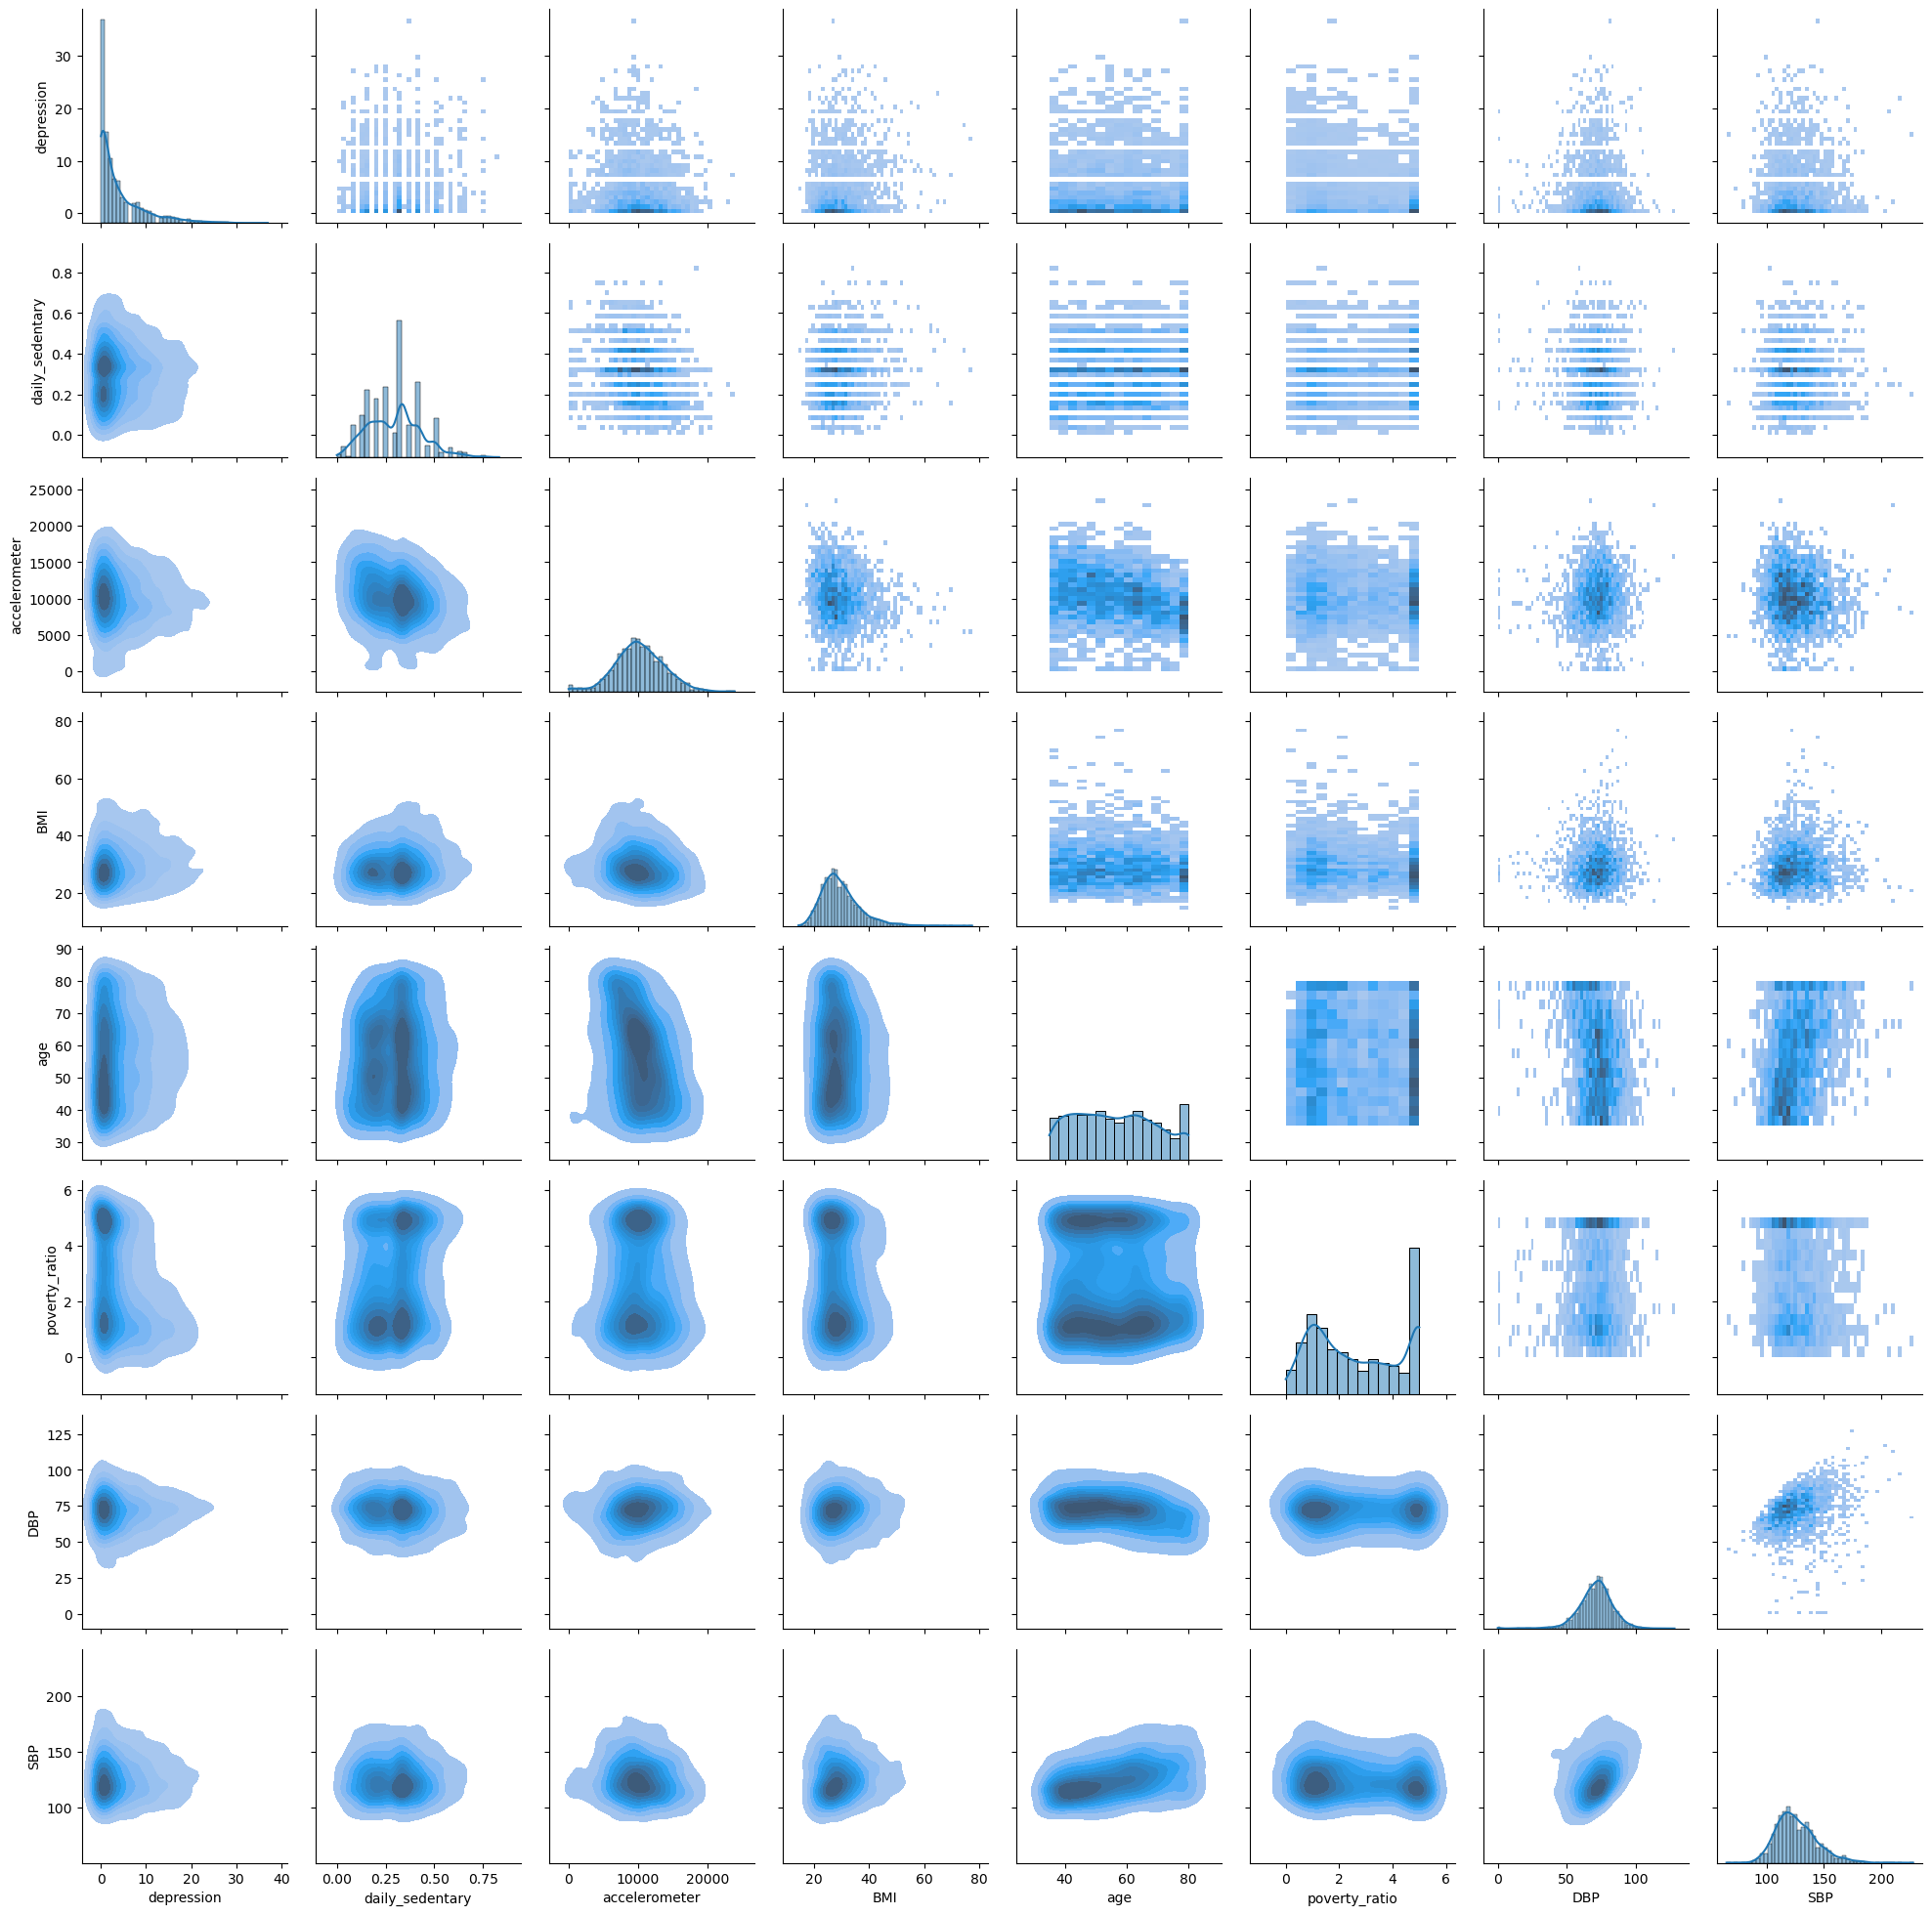

In [10]:
g = sns.PairGrid(df[numerical_cols])
g.map_upper(sns.histplot)
g.map_lower(sns.kdeplot, fill=True)
g.map_diag(sns.histplot, kde=True)

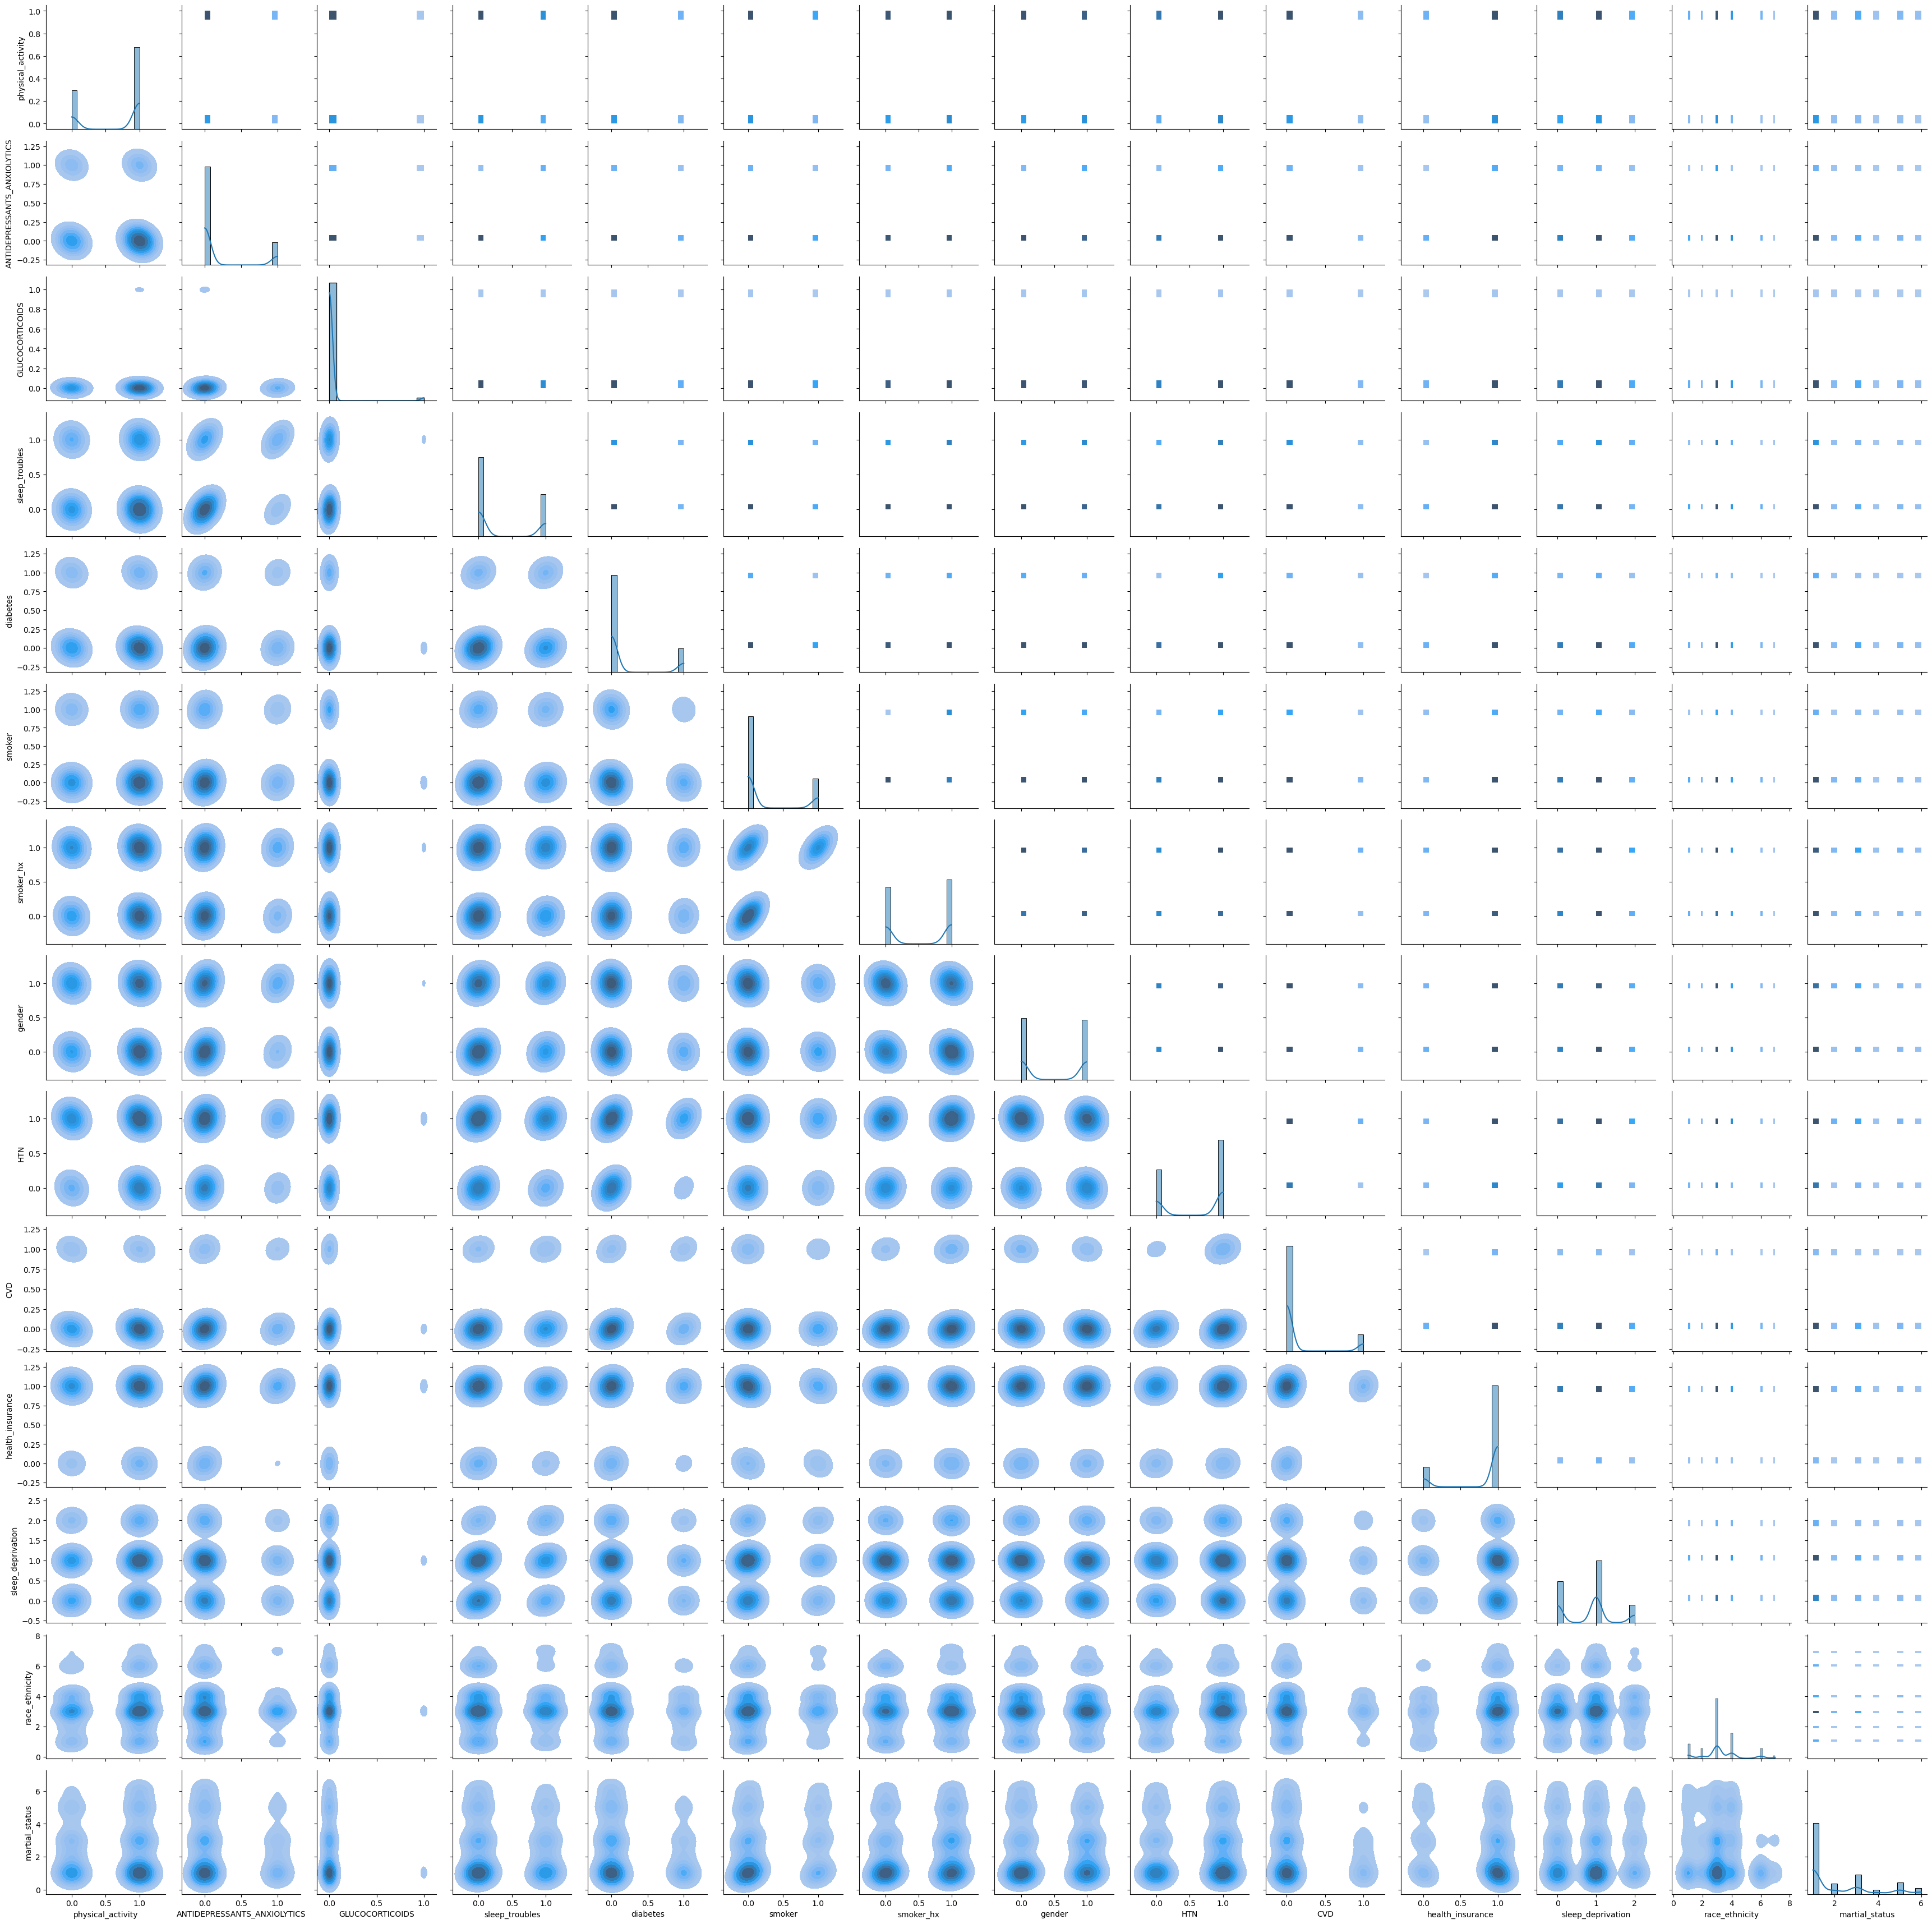

In [9]:
cat_cols_sorted = df[categorical_cols].nunique().sort_values().index
g = sns.PairGrid(df[cat_cols_sorted])
g.map_upper(sns.histplot)
g.map_lower(sns.kdeplot, fill=True)
g.map_diag(sns.histplot, kde=True)

# Transform features for training

In [9]:
# prune df
df.dropna(how='any', inplace=True)
df = df.query(f'age >= {age_cutoff}')

## transform df
# apply scalers
scaler = StandardScaler()
numerical_transformation_cols = list(set(numerical_cols) - set(untransformed_cols))
df[numerical_transformation_cols] = scaler.fit_transform(df[numerical_transformation_cols])

# make z col binary (indicator of recommended max lux value during sleep)
light_cutoff = 1 # nightly minute-mean summed light exposure
df[z_col] = df[z_col].apply(lambda x: 1 if x <= light_cutoff else x)
df[z_col] = df[z_col].apply(lambda x: 0 if x > light_cutoff else x)

# one-hot encode multiclass categoricals
multiclass_cols = df[categorical_cols].columns[df[categorical_cols].nunique() > 2].tolist() 
categorical_transformation_cols = list(set(multiclass_cols) - set(untransformed_cols))
df = one_hot(df, categorical_transformation_cols)
df.columns = df.columns.str.replace('.0', '')

# get df as float
df = df.astype(float)

# get covariates
x_cols = list(set(df.columns) - set([y_col, t_col, z_col]))

# update lists of variable type
all_cols = df.columns
categorical_cols = [x for x in df.columns if any([x.startswith(y) for y in categorical_cols])]

# Check assumptions

## Identification Assumptions

### Positivity

In [12]:
X = df[[z_col, *x_cols]]
T = df[t_col]
Y = df[y_col]

propensity = propensity_estimator(X,T, multiclass=True)['pi']

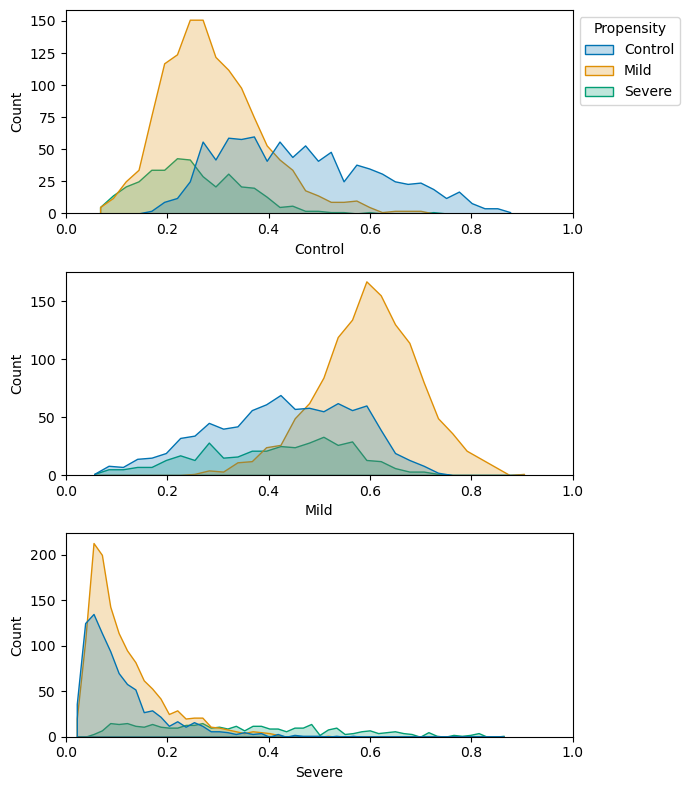

In [23]:
import matplotlib.pyplot as plt
from src.data_dict import sleep_deprivation_dict

fig, axs = plt.subplots(nrows=3, figsize=(7,8))
axs = axs.ravel()

# make copy of df
plot_df = df.copy()

# add propensity
propensity_cols = []
sd_category_dict = {}
for i in range(propensity.shape[1]):
    sd_category = sleep_deprivation_dict[f'{sleep_deprivation_col}_{i}']
    sd_category_dict[i] = sd_category
    propensity_cols.append(sd_category)
plot_df[propensity_cols] = propensity

# replace sleep depivation levels
plot_df['Propensity'] = plot_df[sleep_deprivation_col].astype(int)
plot_df['Propensity'] = plot_df['Propensity'].replace(sd_category_dict)

for i, x in enumerate(propensity_cols):
    legend = True if i == 0 else False
    sns.histplot(
        data=plot_df, 
        x=x, 
        hue="Propensity", 
        palette='colorblind', 
        ax=axs[i],
        legend=legend, 
        element='poly' # poly == vertices centered in bin
    )
    if legend:
        sns.move_legend(axs[i], "upper left", bbox_to_anchor=(1, 1))
    
    axs[i].set(xlim=[0,1])
    
plt.tight_layout()

## Testing Instrumental Variable (IV) assumptions

In [ ]:
import itertools
from math import ceil
import statsmodels.formula.api as smf
from sklearn.feature_selection import f_classif
from sklearn.linear_model import LogisticRegression
from scipy.stats import spearmanr
import matplotlib.pyplot as plt
from src.data_dict import marital_status_dict, race_ethnicity_dict

In [7]:
z_cols = ['ambient_light'] # instrumental variable candidates

In [8]:
# 1. Relevance:
# A high F-statistic (rule of thumb: F > 10) indicates strong relevance 
for z in z_cols:
    # Check the first-stage 2SLS regression (t on z)
    first_stage = smf.ols(formula=f'{t_col} ~ {z}', data=df).fit() # {"+".join([z_col, *x_cols])}
    # print("\nFirst-stage regression:")
    # print(first_stage.summary())
    print(f"\nFirst stage F statistic, {z} : ", first_stage.fvalue)


First stage F statistic, ambient_light :  4.060096843054553


In [15]:
# 2. Exclusion restriction (via correlation of Z with residuals)
for z in z_cols:    
    
    covarites_z =[z, *x_cols]
    
    # Fitting the model; regress outcome on covariates + Z
    linear_model = LogisticRegression()
    linear_model.fit(df[covarites_z], df[y_col])

    # Returning the mean accuracy for the model
    linear_acc = linear_model.score(df[covarites_z], df[y_col])
    print('\nMean accuracy: {0}'.format(linear_acc))

    def calculate_residuals(model, features, label):
        """
        Creates predictions on the features with the model and calculates residuals
        """
        predictions = model.predict(features)
        df_results = pd.DataFrame({'Actual': label, 'Predicted': predictions})
        df_results['Residuals'] = abs(df_results['Actual']) - abs(df_results['Predicted'])
        
        return df_results

    residuals = calculate_residuals(linear_model, df[covarites_z], df[y_col])
    spearman_results = spearmanr(residuals['Residuals'], df[z])
    print(f'Corr. btwn residual error and {z}: {spearman_results.statistic}, p-value={spearman_results.pvalue}')


Mean accuracy: 0.8292108362779741
Corr. btwn residual error and ambient_light: -0.01251275112472432, p-value=0.5279059145034569


/home/hentipapai/miniconda3/envs/cph200b_project3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [16]:
# 3. Exogeneity/Exchangeability (via regression)
# Test for correlations by regressing instruments on observed confounders
# if the coefficients of covariates are statistically significant, it indicates a correlation between the instrument and the corresponding confounder.
for z in z_cols:
    covariates = list(set(x_cols) - set(z))
    regression_z_on_covariates = smf.ols(formula=f'{z} ~ {" + ".join(covariates)}', data=df).fit()
    print(f"\nRegression of {z} on covariates:")
    print(regression_z_on_covariates.summary())


Regression of ambient_light on covariates:
                            OLS Regression Results                            
Dep. Variable:          ambient_light   R-squared:                       0.072
Model:                            OLS   Adj. R-squared:                  0.062
Method:                 Least Squares   F-statistic:                     6.782
Date:                Fri, 28 Mar 2025   Prob (F-statistic):           1.18e-25
Time:                        17:58:25   Log-Likelihood:                -1748.8
No. Observations:                2547   AIC:                             3558.
Df Residuals:                    2517   BIC:                             3733.
Df Model:                          29                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------

In [ ]:
pvalues = regression_z_on_covariates.pvalues.sort_values().to_frame()
pvalues = pvalues.drop('Intercept')
pvalues.columns = ['p-values']
pvalues.index.name = 'feature'
pvalues.reset_index(inplace=True)

# update multicategory names
pvalues.replace({'feature':{**marital_status_dict, **race_ethnicity_dict}}, inplace=True)

# get table in latex
print(pvalues.to_latex(index=False, 
                        formatters={"feature": lambda x: x.replace('_', ' '),
                                    "p-values": "{:.3f}".format},
                        label='tab:exogeneity_test_pvalues',
                        caption=f'Coefficient P-Values, Test of Exogeneity Assumption',
                        sparsify=True))
print('\n')

\begin{table}
\caption{Coefficient P-Values, Test of Exogeneity Assumption}
\label{tab:exogeneity_test_pvalues}
\begin{tabular}{lr}
\toprule
feature & p-values \\
\midrule
accelerometer & 0.000 \\
age & 0.000 \\
gender & 0.000 \\
Mexican American & 0.000 \\
poverty ratio & 0.001 \\
Other Hispanic & 0.001 \\
Divorced & 0.001 \\
BMI & 0.002 \\
Living with partner & 0.003 \\
Non-Hispanic Black & 0.018 \\
Separated & 0.024 \\
Never married & 0.028 \\
Other Race - Including Multi-Racial & 0.046 \\
GLUCOCORTICOIDS & 0.131 \\
daily sedentary & 0.194 \\
sleep troubles & 0.210 \\
Non-Hispanic White & 0.230 \\
SBP & 0.371 \\
smoker & 0.377 \\
race ethnicity 7 & 0.476 \\
Married & 0.485 \\
smoker hx & 0.569 \\
yearly alcohol & 0.714 \\
ANTIDEPRESSANTS ANXIOLYTICS & 0.748 \\
DBP & 0.764 \\
health insurance & 0.783 \\
depression & 0.792 \\
diabetes & 0.794 \\
Widowed & 0.910 \\
CVD & 0.923 \\
physical activity & 0.994 \\
\bottomrule
\end{tabular}
\end{table}





In [23]:
# 3. Exogeneity/Exchangeability (via correlation)
# (implies violation of exclusion restriction, exchangeability, or homogeneity assumptions)
index = pd.MultiIndex.from_product([z_cols, x_cols], names=['z', 'x'])
exogeneity_df = pd.DataFrame(columns=['r', 'pvalue'], index=index)

for z, x in itertools.product(z_cols, x_cols):
    spearman_results = spearmanr(df[z], df[x])
    exogeneity_df.loc[(z, x)] = spearman_results.statistic, spearman_results.pvalue

exogeneity_df.sort_values(by=['z', 'pvalue'], inplace=True)
print(exogeneity_df)

                                                  r    pvalue
z             x                                              
ambient_light accelerometer                0.188323       0.0
              age                         -0.148246       0.0
              poverty_ratio               -0.110585       0.0
              gender                       0.097867  0.000001
              race_ethnicity_3            -0.096853  0.000001
              martial_status_1            -0.084839  0.000018
              daily_sedentary             -0.083587  0.000024
              health_insurance            -0.077402  0.000092
              smoker                       0.067894  0.000606
              race_ethnicity_1             0.067677  0.000631
              martial_status_6             0.067674  0.000632
              CVD                         -0.056747  0.004172
              race_ethnicity_2             0.052946  0.007526
              martial_status_3             0.051674  0.009099
        

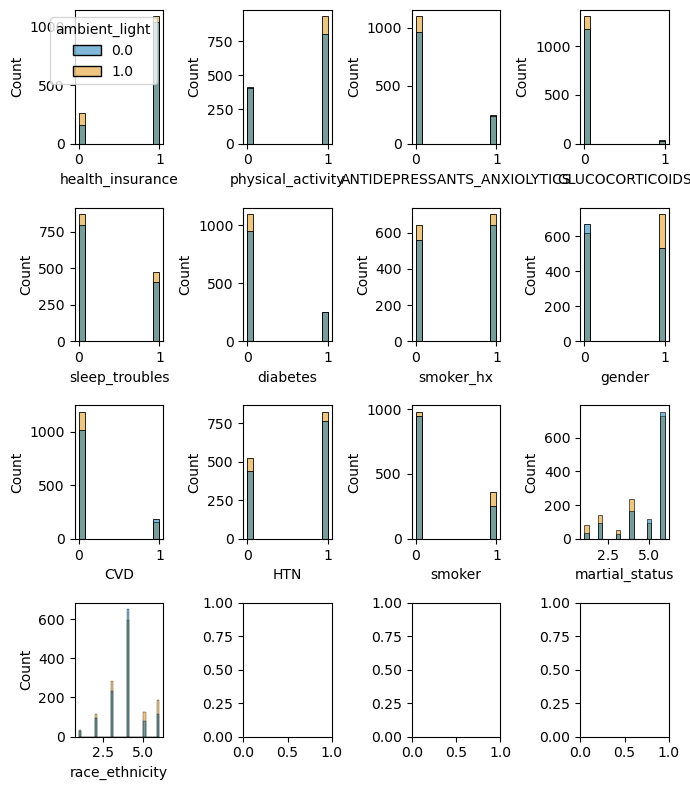

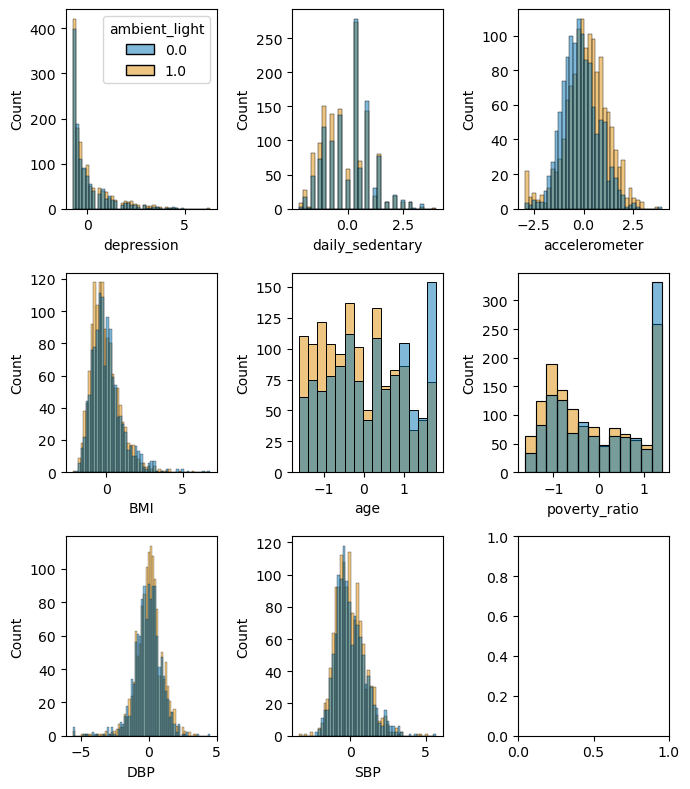

In [15]:
# 3. Exogeneity/Exchangeability (via distribution of measured confounders across levels of the instrument to reveal potential imbalances)
# get histograms
temp_df = df.copy()

for col_set in [categorical_cols, numerical_cols]:
    
    # reduce one-hot encoded categorical cols
    if col_set == categorical_cols:
        for multicategory_col in categorical_transformation_cols:
            
            # get one hot encoded columns
            one_hot_encoded_cols = temp_df.columns[temp_df.columns.str.startswith(multicategory_col)].tolist()
            
            # add categorical col back to df
            temp_df[multicategory_col] = temp_df[one_hot_encoded_cols].sort_index(axis=1).cumsum(axis=1).sum(axis=1)
            
            # remove one hot encoded cols
            temp_df.drop(one_hot_encoded_cols, axis=1, inplace=True)
        
        # update categorical column list
        col_set = [x for x in categorical_cols if not x.startswith(tuple(multiclass_cols))]
        col_set.extend(categorical_transformation_cols)
    
    n_x = len(col_set)
    ncols = ceil(n_x**.5)
    fig, axs = plt.subplots(nrows=ncols, ncols=ncols, figsize=(7,8))
    axs = axs.ravel()
    
    for i, x_col in enumerate(col_set):
        legend = True if i == 0 else False
        sns.histplot(data=temp_df, 
                     x=x_col,
                     hue=z_col,
                     palette='colorblind',
                     multiple='layer',
                     ax=axs[i],
                     legend=legend)
        
        if col_set == categorical_cols:
            axs[i].set(xlim=[0,1])
        
    plt.tight_layout()